In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from autogluon.tabular import TabularDataset, TabularPredictor

c:\Users\ilyes\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\ilyes\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
X_test = pd.read_csv('X_test_GgyECq8.csv')
X_train = pd.read_csv('X_train_Wwou3IE.csv')
y_train = pd.read_csv('y_train_jJtXgMX.csv')
y_pred = pd.read_csv('y_random_pt8afo8.csv')

In [8]:
def compute_weighted_accuracy(y_actual, y_pred):
    # If y_actual is a DataFrame, extract the 'spot_id_delta' column, otherwise assume it's already a numpy array
    if isinstance(y_actual, pd.DataFrame):
        actual = y_actual["spot_id_delta"].values
    else:
        actual = y_actual
    
    # If y_pred is a DataFrame, extract the 'spot_id_delta' column, otherwise assume it's already a numpy array
    if isinstance(y_pred, pd.DataFrame):
        predicted = y_pred["spot_id_delta"].values
    else:
        predicted = y_pred
    
    # actual = y_actual["spot_id_delta"].values
    # predicted = y_pred["spot_id_delta"].values

    correct_direction = (np.sign(actual) == np.sign(predicted)).astype(int)

    weights = np.abs(actual)

    weighted_accuracy = np.sum(correct_direction * weights) / np.sum(weights)

    return round(weighted_accuracy, 2)

In [9]:
def preprocess_data(df):
    # Ensure 'DELIVERY_START' is set as the index with timezone handling
    if 'DELIVERY_START' in df.columns:
        df['DELIVERY_START'] = pd.to_datetime(df['DELIVERY_START'], utc=True)  # Parse with timezone info
        df = df.set_index('DELIVERY_START')
        df.index = df.index.tz_convert('Europe/Berlin')  # Adjust to desired timezone, if needed

    # Add time-related features
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month

    # Handle missing values by filling with the mean of each column
    df = df.fillna(df.mean())

    df = pd.get_dummies(df, drop_first=True)  # Encode categorical variables

    # Drop unwanted columns
    df = df.drop(columns=['predicted_spot_price'], errors='ignore')

    df['delta_load'] = df['load_forecast'] - (df['coal_power_available']+df['gas_power_available']+
                                              df['nucelear_power_available']+df['wind_power_forecasts_average']+
                                              df['solar_power_forecasts_average'])

    df['delta_load_wo_renewables'] = df['load_forecast'] - (df['coal_power_available']+df['gas_power_available']+
                                              df['nucelear_power_available'])
    
    df['renewables_share'] = (df['wind_power_forecasts_average']+df['solar_power_forecasts_average']) / (df['coal_power_available']+df['gas_power_available']+
                                              df['nucelear_power_available']+df['wind_power_forecasts_average']+
                                              df['solar_power_forecasts_average'])
        
    df['wind_share'] = df['wind_power_forecasts_average'] / (df['coal_power_available']+df['gas_power_available']+
                                              df['nucelear_power_available']+df['wind_power_forecasts_average']+
                                              df['solar_power_forecasts_average'])
    
    df['facteur_de_charge'] = (df['coal_power_available'] + df['gas_power_available'] + 
                               df['nucelear_power_available'] + df['wind_power_forecasts_average'] + 
                               df['solar_power_forecasts_average']) / (df['coal_power_available'].max() + 
                                                                        df['gas_power_available'].max() + 
                                                                        df['nucelear_power_available'].max() + 
                                                                        df['wind_power_forecasts_average'].max() + 
                                                                        df['solar_power_forecasts_average'].max())

    df['cyclicite_demand'] = df['load_forecast'] * np.sin(242 * np.pi * df['hour'] / 24)

    return df

def preprocess_y(y):
    # Ensure 'DELIVERY_START' is set as the index
    if 'DELIVERY_START' in y.columns:
        y['DELIVERY_START'] = pd.to_datetime(y['DELIVERY_START'], utc=True)  # Parse with timezone info
        y = y.set_index('DELIVERY_START')
        y.index = y.index.tz_convert('Europe/Berlin')  # Adjust to desired timezone

    return y

def split_train_data(X, y):
    # Ensure indices align during split
    split_size = len(X) // 3
    X_train1, X_train2, X_train3 = X.iloc[:split_size], X.iloc[split_size:2*split_size], X.iloc[2*split_size:]
    y_train1, y_train2, y_train3 = y.iloc[:split_size], y.iloc[split_size:2*split_size], y.iloc[2*split_size:]
    return X_train1, X_train2, X_train3, y_train1, y_train2, y_train3

def train_model(X_train, y_train):
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train.values.ravel())  # Ensure y is passed as a 1D array
    return model

def evaluate_model(model, X, y_actual, task_type):
    # Predict on the given dataset
    predictions = model.predict(X)
    # Use custom weighted accuracy
    y_pred_df = pd.DataFrame(predictions, index=X.index, columns=["spot_id_delta"])
    weighted_acc = compute_weighted_accuracy(y_actual, y_pred_df)

    if task_type == 'regression':
        mse = mean_squared_error(y_actual, predictions)
        mae = mean_absolute_error(y_actual, predictions)
        return mse, mae, weighted_acc
    else: 
        acc = accuracy_score(np.sign(y_actual), predictions)
        return acc, acc, weighted_acc


def tune_hyperparameters(X_train2, y_train2, task_type):
    if task_type == 'classification':
        y_train2 = np.sign(y_train2)
    # Flatten y_train2 to 1D array
    y_train2 = y_train2.values.ravel()  # Ensure y is 1D array
    # Define the model
    rf_model = RandomForestRegressor(random_state=42) if task_type == 'regression' else RandomForestClassifier(random_state=42)

    # Set up the hyperparameter grid
    param_grid = {
        'n_estimators': [1000],
        'max_depth': [10],
    }

    # Perform GridSearchCV
    scoring = 'neg_mean_squared_error' if task_type == 'regression' else 'accuracy'
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring=scoring, n_jobs=-1, verbose=1)
    
    grid_search.fit(X_train2, y_train2)

    # Return the best model and parameters
    return grid_search.best_estimator_, grid_search.best_params_

def plot_feature_importance(model, feature_names):
    # Get the feature importance values from the trained model
    feature_importances = model.feature_importances_
    
    # Create a DataFrame with the feature names and importance values
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })
    
    # Sort the DataFrame by importance value in descending order
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    # Plot the horizontal barplot using seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title('Feature Importance', fontsize=16)
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.show()

def launch(X_train, y_train, X_test, task_type):
    # Preprocess X_train and X_test
    X_train = preprocess_data(X_train)
    X_test = preprocess_data(X_test)

    # Preprocess y_train (only index adjustment)
    y_train = preprocess_y(y_train)

    # Split data into 3 parts
    X_train1, X_train2, X_train3, y_train1, y_train2, y_train3 = split_train_data(X_train, y_train)

    # Tune hyperparameters using the validation set (X_train2 and y_train2)
    best_model, best_params = tune_hyperparameters(X_train2, y_train2, task_type)

    # Train the model on the full training set (X_train1 + X_train2)
    X_train12 = pd.concat([X_train1, X_train2])
    y_train12 = pd.concat([y_train1, y_train2])

    # Flatten y_train_full to 1D array
    y_train12 = y_train12.values.ravel()  # Ensure y is 1D array

    # Train the model on the full training data
    if task_type == 'classification':
        best_model.fit(X_train12, np.sign(y_train12))
    else:
        best_model.fit(X_train12, y_train12)

    # Train train
    train1_metrics = evaluate_model(best_model, X_train1, y_train1, task_type)
    # Validation
    val_metrics = evaluate_model(best_model, X_train2, y_train2, task_type)
    # Train
    train12_metrics = evaluate_model(best_model, X_train12, y_train12, task_type)
    # Test
    test_metrics = evaluate_model(best_model, X_train3, y_train3, task_type)

    # Print evaluation results
    print("Best Model:", best_model)
    print('------------------------------------------------------------------------------------------------------')
    if task_type == 'regression':
        print("Train1 - MSE:", train1_metrics[0], "MAE:", train1_metrics[1], "Weighted Accuracy:", train1_metrics[2])
        print("Validation - MSE:", val_metrics[0], "MAE:", val_metrics[1], "Weighted Accuracy:", val_metrics[2])
        print("Train12 - MSE:", train12_metrics[0], "MAE:", train12_metrics[1], "Weighted Accuracy:", train12_metrics[2])
        print('------------------------------------------------------------------------------------------------------')
        print("Test - MSE:", test_metrics[0], "MAE:", test_metrics[1], "Weighted Accuracy:", test_metrics[2])
    else:
        print("Train1 - Accuracy:", train1_metrics[1], "Weighted Accuracy:", train1_metrics[2])
        print("Validation - Accuracy:", val_metrics[1], "Weighted Accuracy:", val_metrics[2])
        print("Train12 - Accuracy:", train12_metrics[1], "Weighted Accuracy:", train12_metrics[2])
        print('------------------------------------------------------------------------------------------------------')
        print("Test - Accuracy:", test_metrics[1], "Weighted Accuracy:", test_metrics[2])

    # Initialize and train the best model on the entire training dataset
    best_model = RandomForestRegressor(random_state=42) if task_type == 'regression' else RandomForestClassifier(random_state=42)
    best_model.set_params(**best_params)  # Set the best parameters
    if task_type == 'classification':
        best_model.fit(X_train, np.sign(y_train.values.ravel()))
    else:
        best_model.fit(X_train, y_train.values.ravel())

    # Apply model to the actual test dataset
    predictions_test = best_model.predict(X_test)
    y_pred_test = pd.DataFrame(predictions_test, index=X_test.index, columns=["spot_id_delta"])

    # Call the function with the trained model and your data
    plot_feature_importance(best_model, X_test.columns)

    if task_type == 'regression':
        y_train[np.abs(y_train['spot_id_delta'])<100]['spot_id_delta'].hist(bins=100, label='train')
        y_pred_test[np.abs(y_pred_test['spot_id_delta'])<100]['spot_id_delta'].hist(bins=100, label='test')
        plt.legend()

    else:
        np.sign(y_train['spot_id_delta']).hist(bins=10, label='train')
        y_pred_test['spot_id_delta'].hist(bins=10, label='test')
        plt.legend()

    # Save predictions
    y_pred_test.reset_index(inplace=True)
    # y_pred_test.to_csv('y_pred_test.csv', index=False)

    return X_test, best_model, y_pred_test, train1_metrics, val_metrics, train12_metrics, test_metrics

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Model: RandomForestRegressor(max_depth=10, n_estimators=1000, random_state=42)
------------------------------------------------------------------------------------------------------
Train1 - MSE: 473.20326114201777 MAE: 12.664452009707528 Weighted Accuracy: 0.71
Validation - MSE: 1016.3049064240936 MAE: 21.84125871785133 Weighted Accuracy: 0.87
Train12 - MSE: 744.7540837830556 MAE: 17.252855363779428 Weighted Accuracy: 0.82
------------------------------------------------------------------------------------------------------
Test - MSE: 2134.039112237999 MAE: 18.013017254479102 Weighted Accuracy: 0.43


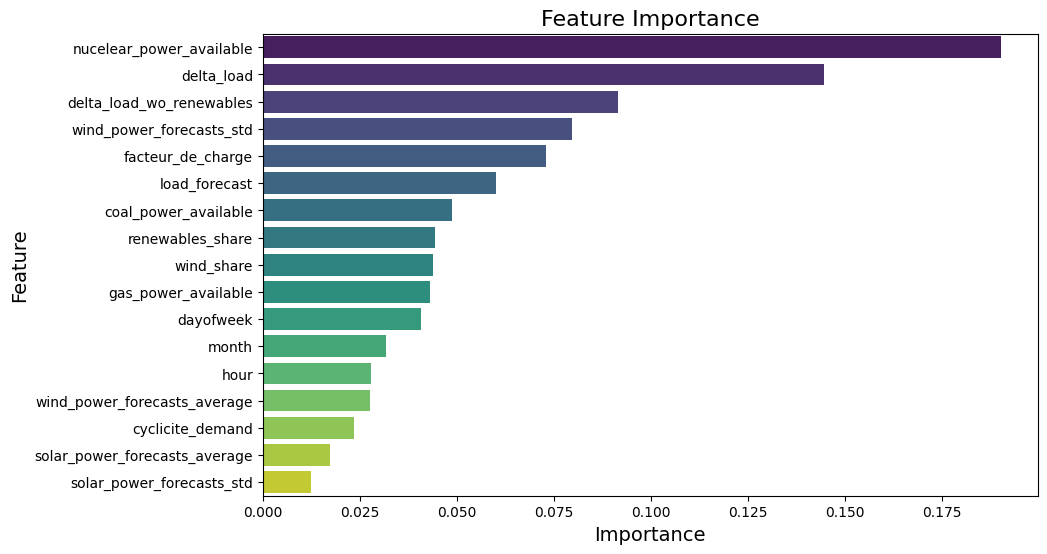

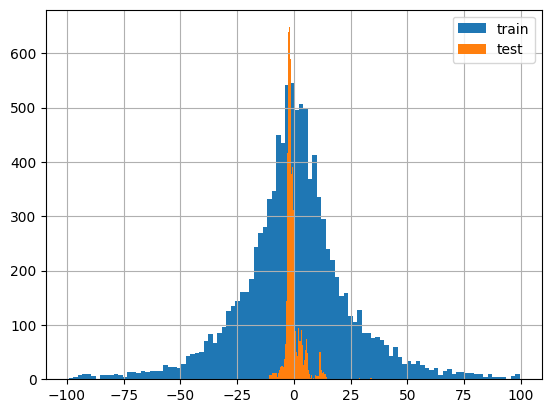

In [10]:
# Execute the pipeline
X_test, model, y_pred_test, train1_metrics, val_metrics, train12_metrics, test_metrics = launch(X_train, y_train, X_test, task_type='regression')